In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.4 MB/s eta 0:00:00


In [3]:
!pip install catboost xgboost lightgbm

### Лабораторная работа 2: Классификация курящих людей

**Цель**: Построить модель для предсказания курения на основе медицинских данных.

**Данные**:
- train.csv - данные для обучения
- test.csv - данные для тестирования

**Задачи**:
1. EDA (разведочный анализ данных)
2. Реализация бэггинга и бустинга
3. Сравнение моделей
4. Подбор гиперпараметров
5. Реализация метрик

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.base import clone
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

import optuna

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

### Разведочный анализ данных (EDA)

In [5]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("First 5 lines of data train.csv:\n")
display(df.head())

print("First 5 lines of data test.csv:\n")
display(df_test.head())

print("Train shape train.csv:", df.shape)
print("Train shape test.csv:", df_test.shape)
print("\nTrain columns train.csv:", df.columns.tolist())
print("\nTrain columns test.csv:", df_test.columns.tolist())

First 5 lines of data train.csv:



,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,...,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,...,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,...,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,...,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,...,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0


First 5 lines of data test.csv:



,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,40.0,155.0,45.0,64.0,0.9,0.9,1.0,1.0,109.0,...,50.0,79.0,108.0,13.3,1.0,0.9,16.0,11.0,17.0,0.0
1,15001,45.0,175.0,90.0,101.0,1.0,1.2,1.0,1.0,130.0,...,147.0,38.0,99.0,16.2,1.0,0.9,23.0,21.0,28.0,1.0
2,15002,40.0,165.0,60.0,78.0,1.5,1.5,1.0,1.0,107.0,...,60.0,67.0,136.0,14.9,1.0,0.9,30.0,36.0,16.0,0.0
3,15003,35.0,170.0,60.0,84.5,1.0,1.0,1.0,1.0,124.0,...,127.0,63.0,128.0,15.4,1.0,0.8,21.0,17.0,26.0,1.0
4,15004,40.0,155.0,45.0,68.5,1.0,1.0,1.0,1.0,109.0,...,47.0,61.0,133.0,11.5,1.0,0.7,22.0,12.0,17.0,0.0


Train shape train.csv: (15000, 24)
Train shape test.csv: (10000, 23)

Train columns train.csv: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']

Train columns test.csv: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


In [6]:
print("Missing values train.csv:\n")
print(df.isnull().sum())

print("\nMissing values test.csv:\n")
print(df_test.isnull().sum())

Missing values train.csv:

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Missing values test.csv:

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyce

In [7]:
print("\nTrain describe train.csv:\n\n", df.describe())
print("\nTrain describe test.csv:\n\n", df_test.describe())


Train describe train.csv:

                  id           age    height(cm)    weight(kg)     waist(cm)  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    7499.500000     42.606000    164.672667     64.282000     80.323180   
std     4330.271354     10.415341      8.558684     10.973871      7.932701   
min        0.000000     20.000000    140.000000     35.000000      0.900000   
25%     3749.750000     40.000000    160.000000     55.000000     75.000000   
50%     7499.500000     40.000000    165.000000     65.000000     80.000000   
75%    11249.250000     50.000000    170.000000     70.000000     86.000000   
max    14999.000000     80.000000    190.000000    120.000000    121.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count    15000.000000     15000.000000   15000.000000    15000.000000   
mean         1.032727         1.025927       1.005533        1.004933   
std          0.312845         0.313488  

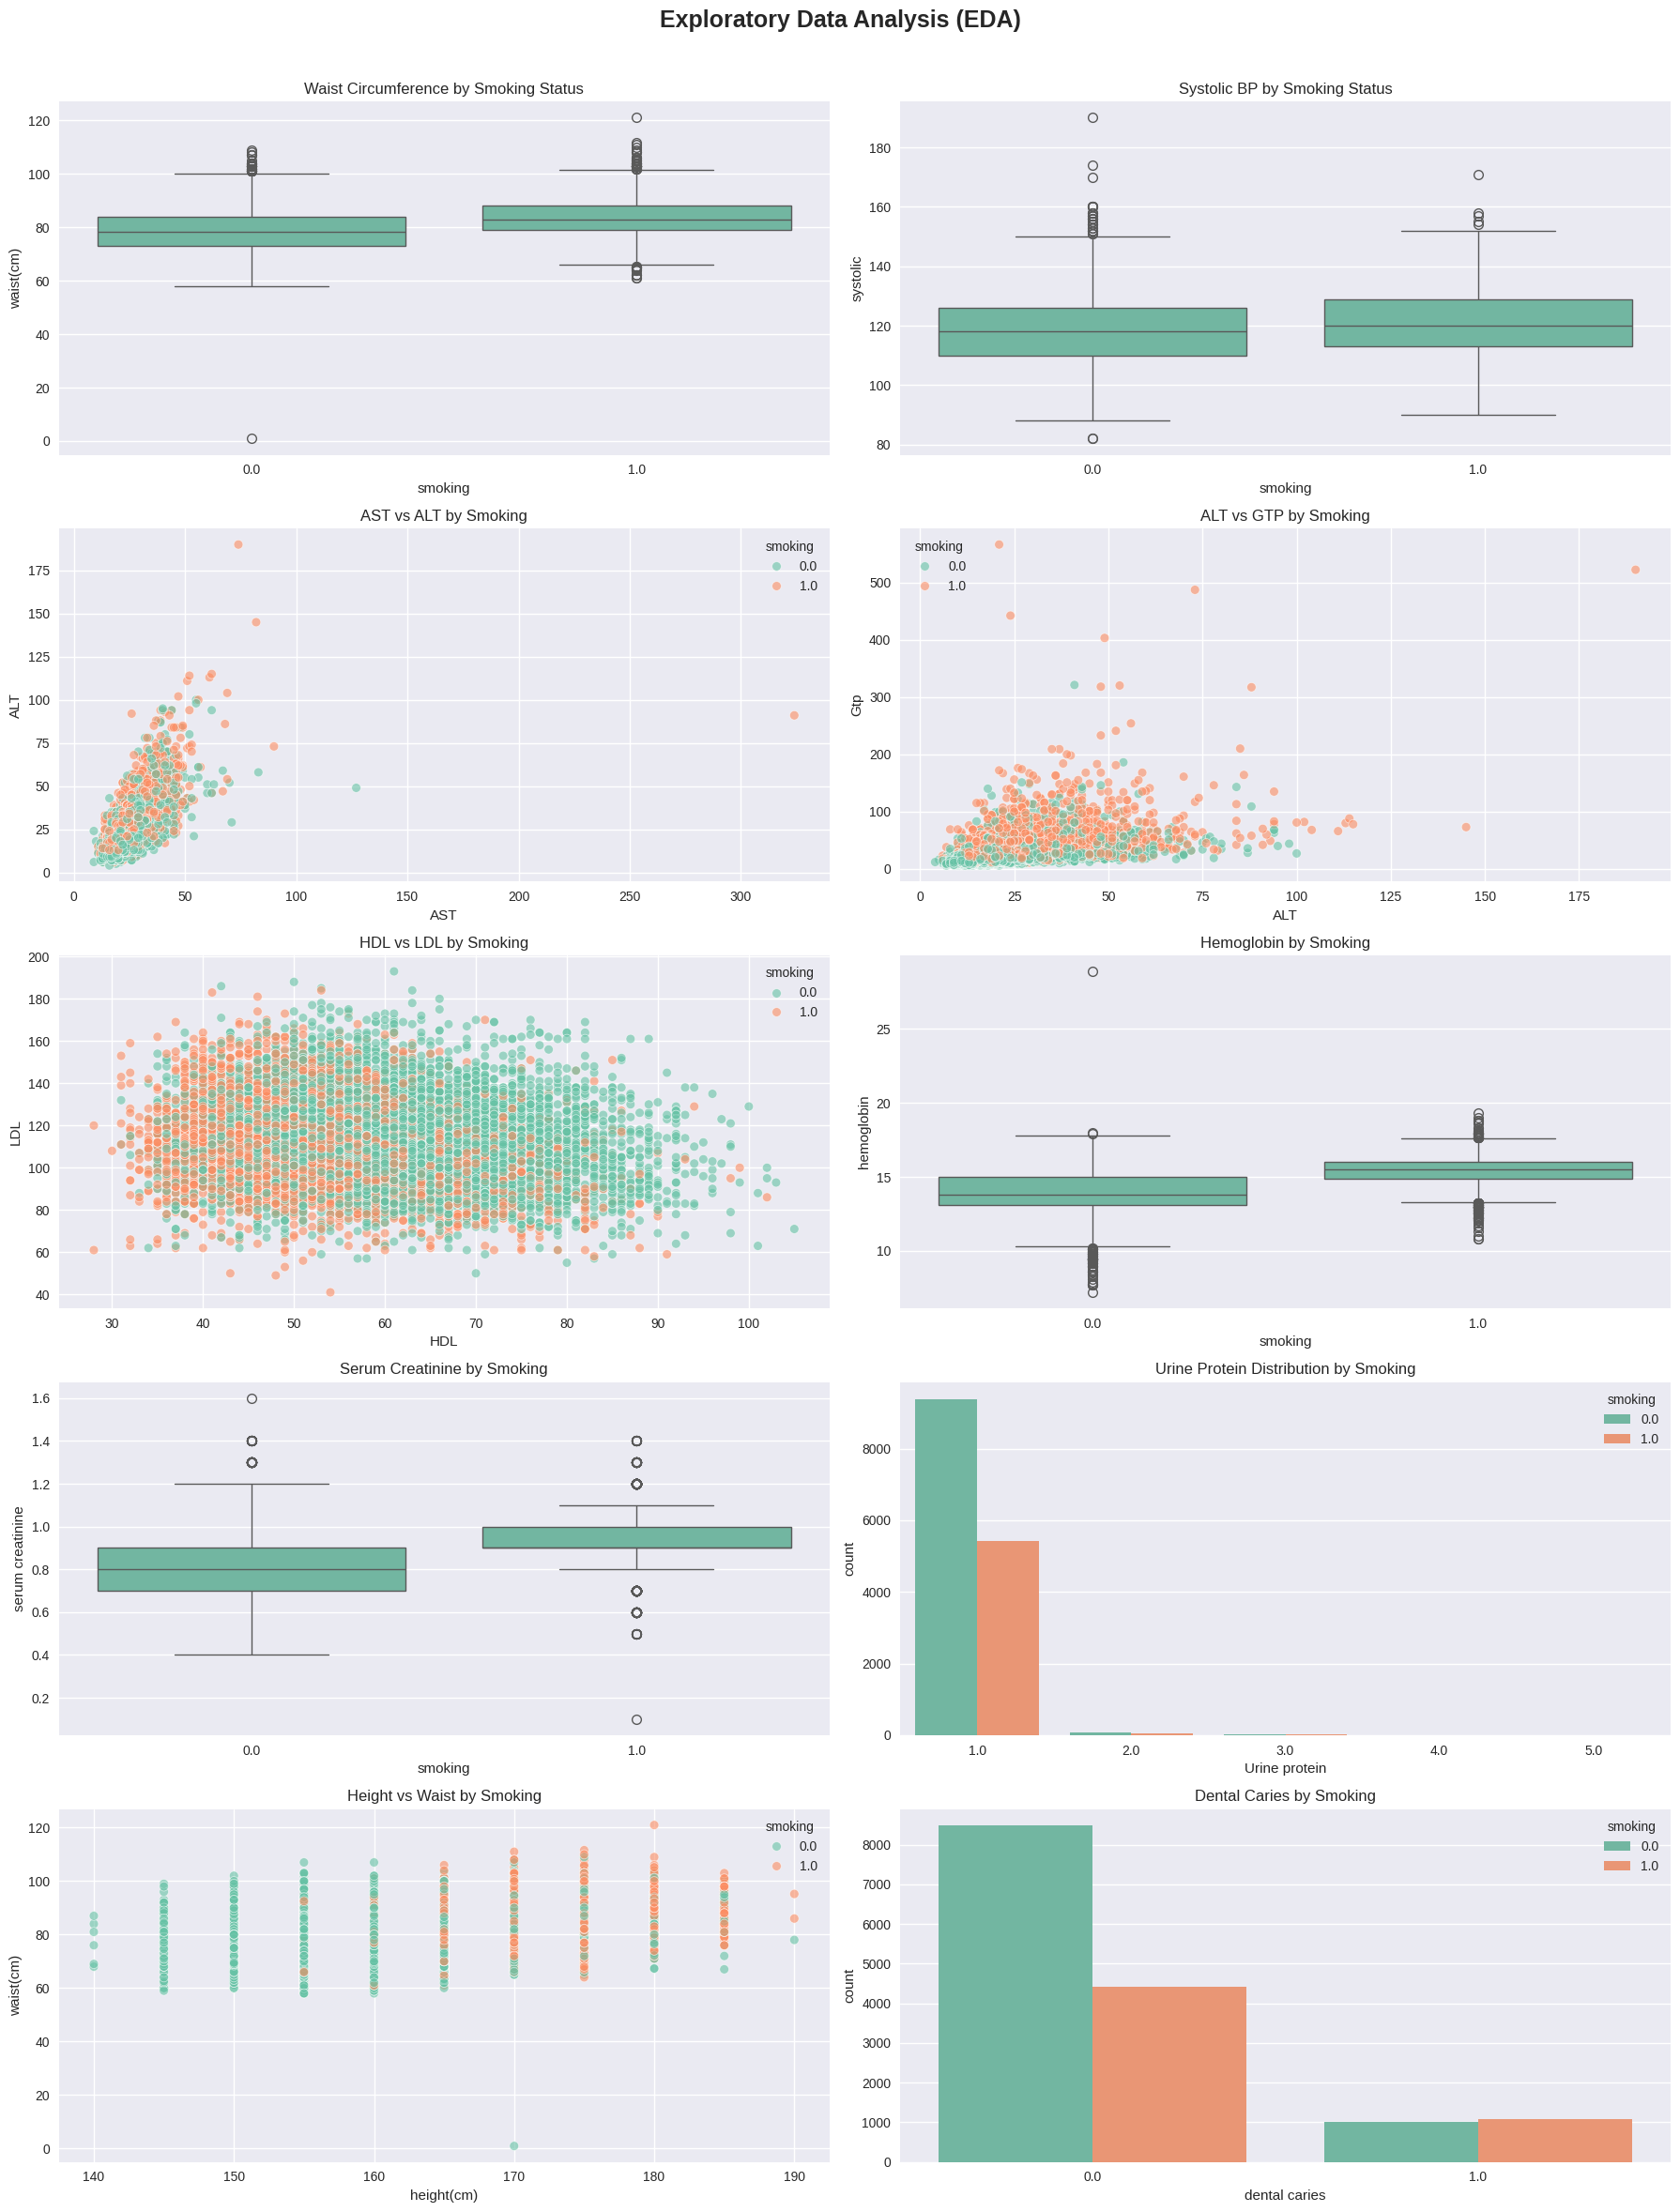

In [10]:
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

fig, axes = plt.subplots(5, 2, figsize=(18, 24))
fig.suptitle('Exploratory Data Analysis (EDA)', fontsize=18, fontweight='bold')

sns.boxplot(x='smoking', y='waist(cm)', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Waist Circumference by Smoking Status')

sns.boxplot(x='smoking', y='systolic', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Systolic BP by Smoking Status')

sns.scatterplot(x='AST', y='ALT', hue='smoking', data=df, alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('AST vs ALT by Smoking')

sns.scatterplot(x='ALT', y='Gtp', hue='smoking', data=df, alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title('ALT vs GTP by Smoking')

sns.scatterplot(x='HDL', y='LDL', hue='smoking', data=df, alpha=0.6, ax=axes[2, 0])
axes[2, 0].set_title('HDL vs LDL by Smoking')

sns.boxplot(x='smoking', y='hemoglobin', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Hemoglobin by Smoking')

sns.boxplot(x='smoking', y='serum creatinine', data=df, ax=axes[3, 0])
axes[3, 0].set_title('Serum Creatinine by Smoking')

sns.countplot(x='Urine protein', hue='smoking', data=df, ax=axes[3, 1])
axes[3, 1].set_title('Urine Protein Distribution by Smoking')

sns.scatterplot(x='height(cm)', y='waist(cm)', hue='smoking', data=df, alpha=0.6, ax=axes[4, 0])
axes[4, 0].set_title('Height vs Waist by Smoking')

sns.countplot(x='dental caries', hue='smoking', data=df, ax=axes[4, 1])
axes[4, 1].set_title('Dental Caries by Smoking')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Матрица корреляций

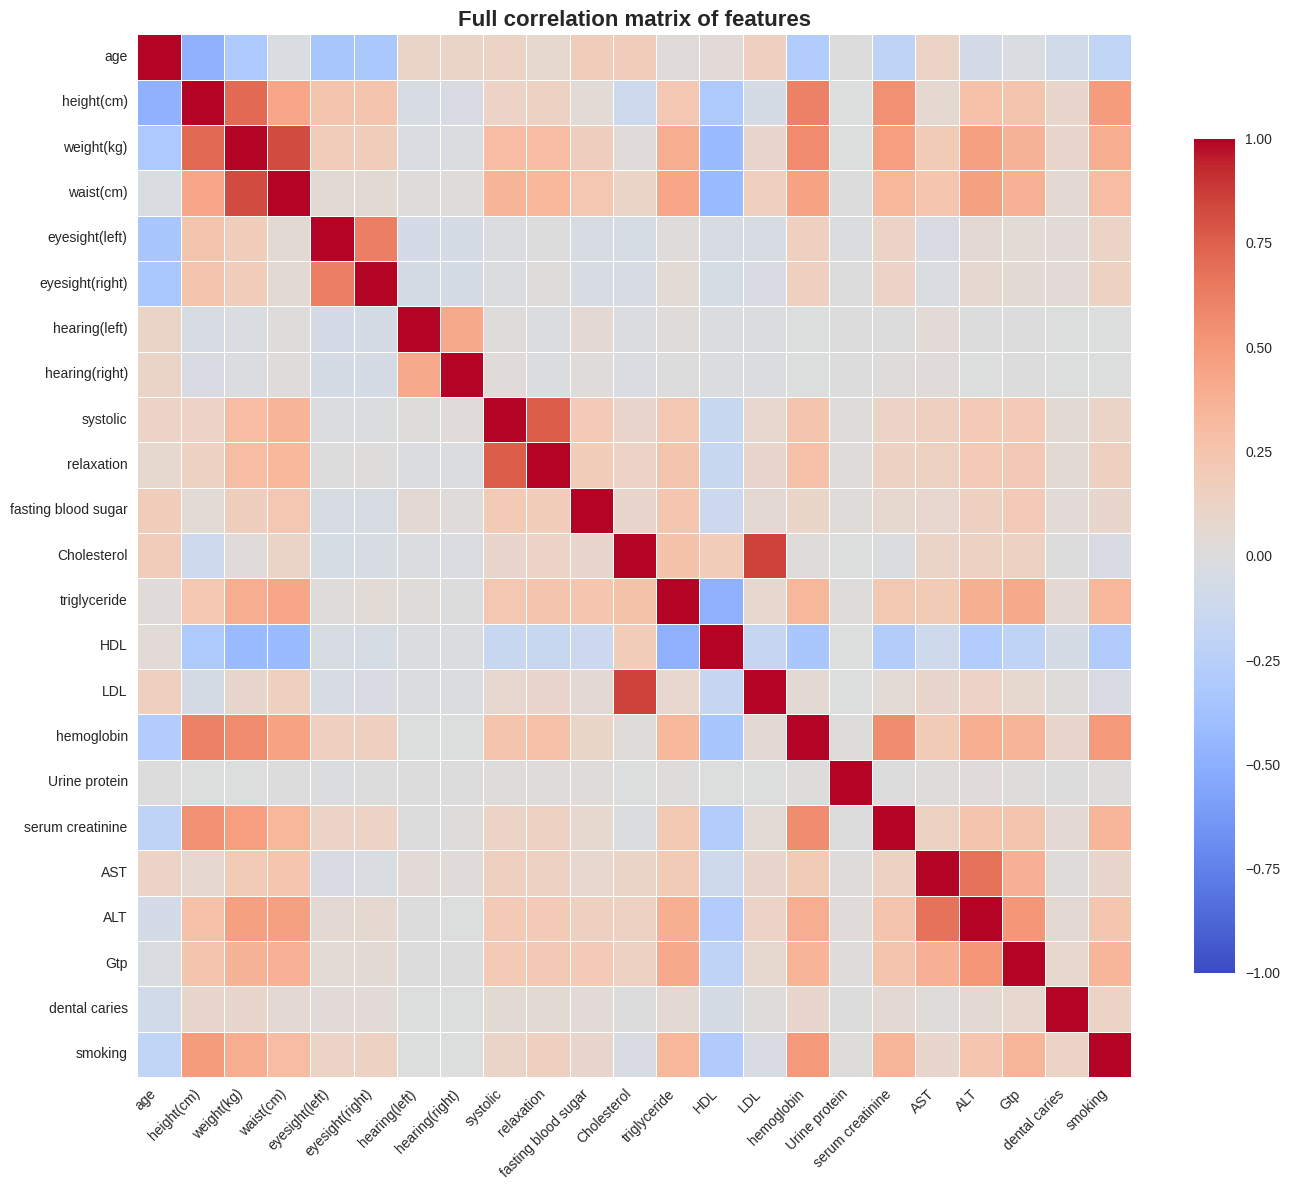

In [11]:
plt.figure(figsize=(14, 12))
corr_matrix = df.drop(columns='id').corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)
plt.title('Full correlation matrix of features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Реализация бэггинга

In [ ]:
class MyBaggingClassifier:
    """
    Параметры:
    - base_model: базовая модель для ансамбля
    - n_models: количество моделей в ансамбле
    - random_state: случайное состояние для воспроизводимости
    """
    def __init__(self, base_model, n_models=10, random_state=None):
        self.base_model = base_model
        self.n_models = n_models
        self.models = []
        self.random_state = random_state

    def fit(self, X, y):
        """
        Обучение:
        X: признаки (numpy array или pandas DataFrame)
        y: целевая переменная (numpy array или pandas Series)
        """
        np.random.seed(self.random_state)
        for i in range(self.n_models):
            # Бутстрэп выборка
            idx = np.random.choice(len(X), size=len(X), replace=True)
            # Работаем и с numpy array, и с pandas DataFrame
            X_sample = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx]
            y_sample = y[idx] if isinstance(y, np.ndarray) else y.iloc[idx]

            # Обучение модели
            model = clone(self.base_model)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        """
        Предсказание вероятностей
        """
        probas = [model.predict_proba(X) for model in self.models]
        return np.mean(probas, axis=0)

    def predict(self, X):
        """
        Предсказание классов
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

### Подготовка данных

In [ ]:
X = df.drop(['id', 'smoking'], axis=1)
y = df['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test.drop('id', axis=1)

### Сравнение бэггинга

In [ ]:
base_model = DecisionTreeClassifier(max_depth=3)
my_bagging = MyBaggingClassifier(base_model=base_model, n_models=10, random_state=42)
my_bagging.fit(X_train, y_train)
my_pred = my_bagging.predict_proba(X_val)[:, 1]

sklearn_bagging = BaggingClassifier(base_model, n_estimators=10, random_state=42)
sklearn_bagging.fit(X_train, y_train)
sklearn_pred = sklearn_bagging.predict_proba(X_val)[:, 1]

print(f"\nMy Bagging ROC-AUC: {roc_auc_score(y_val, my_pred):.4f}")
print(f"Sklearn Bagging ROC-AUC: {roc_auc_score(y_val, sklearn_pred):.4f}")


My Bagging ROC-AUC: 0.8473
Sklearn Bagging ROC-AUC: 0.8528


### Реализация градиентного бустинга

In [ ]:
class MyGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        # Начальное предсказание - лог-оддсы
        self.initial_pred = np.log(np.mean(y) / (1 - np.mean(y)))
        pred = np.full(X.shape[0], self.initial_pred)

        for _ in range(self.n_estimators):
            # Градиент (псевдо-остатки)
            residuals = y - self._sigmoid(pred)

            # Обучаем дерево на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)
            self.models.append(tree)

            # Обновляем предсказания
            pred += self.learning_rate * tree.predict(X)

        return self

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.initial_pred)
        for model in self.models:
            pred += self.learning_rate * model.predict(X)
        proba = self._sigmoid(pred)
        return np.vstack([1-proba, proba]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

### Сравнение бустинга

In [ ]:
my_gb = MyGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
my_gb.fit(X_train, y_train)
my_pred = my_gb.predict_proba(X_val)[:, 1]

sklearn_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                      max_depth=3, random_state=42)
sklearn_gb.fit(X_train, y_train)
sklearn_pred = sklearn_gb.predict_proba(X_val)[:, 1]

print(f"\nMy GB ROC-AUC: {roc_auc_score(y_val, my_pred):.4f}")
print(f"Sklearn GB ROC-AUC: {roc_auc_score(y_val, sklearn_pred):.4f}")


My GB ROC-AUC: 0.8700
Sklearn GB ROC-AUC: 0.8898


### Сравнение библиотек бустинга

In [ ]:
def compare_boosters(X_train, y_train, X_val, y_val):
    models = {
        "Sklearn GB": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=42),
        "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, pred)
        results.append((name, auc))
        print(f"{name}: ROC-AUC = {auc:.4f}")

    return max(results, key=lambda x: x[1])

best_model_name, best_auc = compare_boosters(X_train, y_train, X_val, y_val)
print(f"\nThe best model: {best_model_name} с ROC-AUC = {best_auc:.4f}")

Sklearn GB: ROC-AUC = 0.8898
XGBoost: ROC-AUC = 0.8813
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4359, number of negative: 7641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.363250 -> initscore=-0.561286
[LightGBM] [Info] Start training from score -0.561286
LightGBM: ROC-AUC = 0.8911
CatBoost: ROC-AUC = 0.8921

The best model: CatBoost с ROC-AUC = 0.8921


### Подбор гиперпараметров

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 6, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 20),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.5),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
    }

    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  ROC-AUC: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

final_model = CatBoostClassifier(
    **trial.params,
    random_state=42,
    verbose=0
)
final_model.fit(X_train, y_train)

[I 2025-05-12 07:41:51,870] A new study created in memory with name: no-name-ea489afa-7ab4-42dd-852b-2d2637f5bfc5
[I 2025-05-12 07:42:15,394] Trial 0 finished with value: 0.8873160724391624 and parameters: {'iterations': 1978, 'depth': 6, 'learning_rate': 0.02422470341938635, 'l2_leaf_reg': 15.752687916108396, 'border_count': 172, 'random_strength': 1.1462497812765409, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 29, 'bagging_temperature': 0.2611123997439828}. Best is trial 0 with value: 0.8873160724391624.
[I 2025-05-12 07:42:45,584] Trial 1 finished with value: 0.8875103754008676 and parameters: {'iterations': 2346, 'depth': 6, 'learning_rate': 0.020129506741229646, 'l2_leaf_reg': 9.180995610697009, 'border_count': 139, 'random_strength': 0.43492705382550134, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 10, 'bagging_temperature': 0.09088079857484332}. Best is trial 1 with value: 0.8875103754008676.
[I 2025-05-12 07:43:04,238] Trial 2 finished with value: 0.8864266176193171 and 

Best trial:
  ROC-AUC: 0.8940
  Params: 
    iterations: 1471
    depth: 8
    learning_rate: 0.007197523456421798
    l2_leaf_reg: 19.335455886389113
    border_count: 235
    random_strength: 0.8569342765338678
    grow_policy: Lossguide
    min_data_in_leaf: 50
    bagging_temperature: 0.9994630943083231


### Загрузка файла

In [ ]:
test_preds = final_model.predict_proba(X_test.values)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'smoking': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


### Реализация метрик

In [ ]:
def my_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def my_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def my_f1(y_true, y_pred):
    precision = my_precision(y_true, y_pred)
    recall = my_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

y_pred = final_model.predict(X_val)

print("\nMy Accuracy:", my_accuracy(y_val, y_pred))
print("Sklearn Accuracy:", accuracy_score(y_val, y_pred))

print("\nMy Precision:", my_precision(y_val, y_pred))
print("Sklearn Precision:", precision_score(y_val, y_pred))

print("\nMy Recall:", my_recall(y_val, y_pred))
print("Sklearn Recall:", recall_score(y_val, y_pred))

print("\nMy F1:", my_f1(y_val, y_pred))
print("Sklearn F1:", f1_score(y_val, y_pred))


My Accuracy: 0.8176666666666667
Sklearn Accuracy: 0.8176666666666667

My Precision: 0.7481171548117155
Sklearn Precision: 0.7481171548117155

My Recall: 0.7842105263157895
Sklearn Recall: 0.7842105263157895

My F1: 0.7657387580299785
Sklearn F1: 0.7657387580299786


In [ ]:
def my_roc_auc(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    tpr = []
    fpr = []

    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tn = np.sum((y_true == 0) & (y_pred == 0))

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

    auc = 0
    for i in range(1, len(thresholds)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

    return auc

y_scores = final_model.predict_proba(X_val)[:, 1]

print("\nMy ROC-AUC:", my_roc_auc(y_val, y_scores))
print("\nSklearn ROC-AUC:", roc_auc_score(y_val, y_scores))

print("\nMy PR-AUC:", average_precision_score(y_val, y_scores))


My ROC-AUC: 0.893984625542363

Sklearn ROC-AUC: 0.8939846255423505

My PR-AUC: 0.803342882787774
